In [1]:
import requests
from tqdm import tqdm
import pandas as pd
# from owlready2 import get_ontology
import os

from modul.standardization_usingsparql import addTaxonColumn, buat_kolom_taxon_awal
from modul.disambiguation_optimized import buat_kamus_kosong, update_kamus_pake_wikidata, update_df_pake_kamus, update_df_pake_path_ujung, removeOtherThanNCBI
from modul.preprocess import cleaning, splitInteractionToNodeEdge
from modul.filterNodeEdge import removeNodeAndEdgeByFilter,takeNodeAndEdgeByFilter,removeEdgesNotInNodes
from modul.helper_umum import contains_string_entire_column,contains_string_entire_column_boolean
from modul.vectorReferenced import get_taxon_vector,cek_ncbi_id_by_wiki_id_via_string

In [175]:
data_init=[
    ('1cucu','Cucumber mosaic virus','Aphididae','Myzus persicae'),
    ('2cri','Tomato chlorosis virus','Aleyrodidae','Bemisia Tabaci'),
    ('3wai','Maize chlorotic dwarf virus','Cicadellidae','Graminella nigrifrons'),
    ('4beg','Tomato yellow leaf curl China virus','Aleyrodidae','Bemisia Tabaci'),
    ('5pol','Cereal yellow dwarf virus','Aphididae','Schizaphis graminum'),
    ('6pea','Pea enation mosaic virus 1','Aphididae','Acyrthosiphon pisum'),
    ('7cucur','Cucurbit yellow stunting disorder virus','Aleyrodidae','Bemisia Tabaci'),
    ('8ten','Rice stripe tenuivirus','Delphacidae','Laodelphax striatellus'),
    ('9fiji','Southern rice black-streaked dwarf virus','Delphacidae','Sogatella furcifera'),
    ('10capchlo','Capsicum chlorosis orthotospovirus','Thripidae','Thrips Palmi'),
    ('11barley','Barley yellow dwarf virus GAV','Aphididae','Sitobion avenae'),
    ('12tospot','Tomato spotted wilt orthotospovirus','Thripidae','Frankliniella occidentalis'),
    # error dibawah ini
    # ('+13Poty','Potyvirus','Aphididae','Myzus'),
    # ('+11tung','Tungrovirus','Nilaparvata','Nilaparvata'),
]

In [176]:
#1 inisiasi
ini_data=data_init[4]
#parameter
nama_file = ini_data[0]
virus_txt = ini_data[1].replace(' ','%20')
tipe_interaksi_virus = 'hasHost' #pathogenOf, pake relasi hasHost lebih dapat banyak relasi dari pada pathogenOf
tipe_interaksi_tanaman = 'hostOf' #hasPathogen, pake relasi hostOf lebih dapat banyak relasi dari pada hasPathogen
tipe_interaksi_serangga_ke_tanaman = 'hasHost' 
tipe_interaksi_serangga_ke_virus = 'hostOf' 
ncbi_server_url = 'http://localhost:3030/mydataset/query'

In [177]:
virus_search = get_taxon_vector(virus_txt,ncbi_server_url)
if (virus_search==False):
    virus_search=[('unknown',virus_txt)]
virus_search

[('spesies', 'NCBI:191032_Cereal yellow dwarf virus-RPV satellite RNA'),
 ('superkingdom', 'NCBI:10239_Viruses')]

In [178]:
#2 ambil data dari globi
kolom=[
    'source_taxon_external_id',
    'source_taxon_name',
    'source_taxon_path',
    'source_taxon_path_ids',
    'source_taxon_path_ranks',
    
    'interaction_type',
    
    'target_taxon_external_id',
    'target_taxon_name',
    'target_taxon_path',
    'target_taxon_path_ids',
    'target_taxon_path_ranks',
]

interactionType=tipe_interaksi_virus
print('layer 1 pertama',virus_search[0][1].split('_'))
link="https://api.globalbioticinteractions.org/interaction?sourceTaxon="+virus_search[0][1].split('_')[0]+"&interactionType="+interactionType+"&fields="+(','.join(kolom))
response = requests.get(link)
res=response.json()
if not res['data']:
    print('stop kosong')
# JSON To Pandas Dataframe
df = pd.json_normalize(res, record_path =['data'])

if(len(virus_search) == 1):
    pass
elif(virus_search[1][0] not in ['famili','genus']):
    pass
else:
    print('layer 1 kedua',virus_search[1][1].split('_'))
    link="https://api.globalbioticinteractions.org/interaction?sourceTaxon="+virus_search[1][1].split('_')[0]+"&interactionType="+interactionType+"&fields="+(','.join(kolom))
    response = requests.get(link)
    res=response.json()
    if not res['data']:
        print('kosong')
    # JSON To Pandas Dataframe
    df_ = pd.json_normalize(res, record_path =['data'])
    df=pd.concat([df,df_])

df.columns = kolom

layer 1 pertama ['NCBI:191032', 'Cereal yellow dwarf virus-RPV satellite RNA']


In [179]:
#3 splitting layer 1 interaksi virus
df_node, df_edge = splitInteractionToNodeEdge(df)

In [180]:
#4 cleaning_after_get layer 1 interaksi virus
df_node.drop_duplicates(inplace=True)
no_ncbi_and_path_null=(df_node.taxon_id.str.contains('NCBI')==False) & (df_node.taxon_path_ids.isnull())
df_node,df_edge = removeNodeAndEdgeByFilter(df_node[no_ncbi_and_path_null], df_node,df_edge) 
df_edge.drop_duplicates(inplace=True)

In [181]:
#4a tandai virus utama
filter_virus_utama=(
    (df_node.taxon_name.str.contains('virus',case=False))
    | (df_node.taxon_path.str.contains('virus', case=False)) 
    #jika berawalan atau berakhiran kata virus
)
# df_node.loc[filter_virus_utama, ['virus_utama']] = True
virus_utama=[data.taxon_id for idx,data in df_node[filter_virus_utama].iterrows()]

In [182]:
#5 disambiguasi layer 1 interaksi virus
kamus_ncbi = buat_kamus_kosong(df_node)
kamus_ncbi = update_kamus_pake_wikidata(kamus_ncbi)
#update dataframe pake kamus
df_node,df_edge = update_df_pake_kamus(kamus_ncbi,df_node,df_edge)
df_node,df_edge = update_df_pake_path_ujung(df_node,df_edge)

[] 0  database,  0  kali perulangan akses NCBI


In [183]:
#untuk laporan
#kode database
print(kamus_ncbi.keys())

key=[]
val=[]
for i in kamus_ncbi:
    key.extend(list(kamus_ncbi[i].keys()))
    val.extend(list(kamus_ncbi[i].values()))
    
df_kamus=pd.DataFrame({'key':key,'val':val})

# csv
# df_kamus.to_csv('output.xlsx', index=False)

# semua 
# df_kamus
# yang kosong
df_kamus[(df_kamus.val != '')].count()

dict_keys([])


key    0
val    0
dtype: int64

In [184]:
#6 standarisasi layer 1 interaksi virus
df_node = buat_kolom_taxon_awal(df_node) #buat kolom taxon, default none
df_node = addTaxonColumn(df_node,'http://localhost:3030/mydataset/query') # isi pake ncbi
df_node, df_edge = removeOtherThanNCBI(df_node,df_edge)# Hapus kalo masih ada selain NCBI
df_edge = removeEdgesNotInNodes(df_node, df_edge) #hapus edge yang tidak ada nodenya

set()
------------------------------------
node
sebelum  4
sesudah  4
edge
target: sebelum 3
target: sesudah 3
source: sebelum 3
source: sesudah 3


In [185]:
# cleaning_after_disambiguasi layer 1
# 7 hapus node yang ordo_sampai_species_null
filter_ordo_sampai_species_null=(
    (df_node.order.isnull())
    & (df_node.family.isnull())
    & (df_node.genus.isnull())
    & (df_node.species.isnull())
)
df_node,df_edge = removeNodeAndEdgeByFilter(df_node[filter_ordo_sampai_species_null], df_node,df_edge)

In [186]:
#7 pengambilan interaksi tanaman
df_plant=df_node[df_node.kingdom=='NCBI:33090_Viridiplantae']
interactionType=tipe_interaksi_tanaman
node_to_add=pd.DataFrame(columns = [
    'taxon_id',
    'taxon_name',
    'taxon_path',
    'taxon_path_ids',
    'taxon_path_rank',
])
edge_to_add=pd.DataFrame(columns = [
    'source_taxon_id',
    'target_taxon_id',
    'interaction_type',
])
kebalikan={
    'hostOf':'hasHost',
    'hasPathogen':'pathogenOf', 
    'pollinatedBy':'pollinates', 
    'flowersVisitedBy':'visitFlowersOf',
    'visitedBy':'visit'
}
#tanaman
for idx,i in tqdm(df_plant.iterrows(), total=df_plant.shape[0]):
    plant=i.taxon_name.replace(' ','%20')
    link="https://api.globalbioticinteractions.org/interaction?sourceTaxon="+plant+"&interactionType="+interactionType+"&fields="+(','.join(kolom))
    response = requests.get(link)
    res=response.json()
    #list data
    taxon_id=[]
    taxon_name=[]
    taxon_path=[]
    taxon_path_ids=[]
    taxon_path_rank=[]
    interaction_type=[]
    for x in res['data']:
        taxon_id.append(x[6])
        taxon_name.append(x[7])
        taxon_path.append(x[8])
        taxon_path_ids.append(x[9])
        taxon_path_rank.append(x[10])
        if x[5] in ['hostOf', 'hasPathogen', 'pollinatedBy', 'flowersVisitedBy','visitedBy']:
            interaction_type.append(kebalikan[x[5]])
        else:
            interaction_type.append('patogennya')
    ## NODE
    #concat ke dataframe lama
    node_to_add = pd.concat([
        node_to_add,
        pd.DataFrame({
            'taxon_id':taxon_id,
            'taxon_name':taxon_name,
            'taxon_path':taxon_path,
            'taxon_path_ids':taxon_path_ids,
            'taxon_path_rank':taxon_path_rank,
        })
    ], ignore_index = True)
    node_to_add.reset_index()
    ## EDGE
    #concat ke dataframe lama
    edge_to_add = pd.concat([
        edge_to_add,
        pd.DataFrame({
            'source_taxon_id': taxon_id, # patogen
            'target_taxon_id': i.taxon_id, # tanaman
            'interaction_type': interaction_type})
    ], ignore_index = True)
    edge_to_add.reset_index()

100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


In [187]:
# 7 pengambilan interaksi serangga -> tanaman
df_insect = df_node[df_node['class']=='NCBI:50557_Insecta']
interactionType = tipe_interaksi_serangga_ke_tanaman
#serangga
for idx,i in tqdm(df_insect.iterrows(), total=df_insect.shape[0]):
    insect=i.taxon_name.replace(' ','%20')
    link="https://api.globalbioticinteractions.org/interaction?sourceTaxon="+insect+"&interactionType="+interactionType+"&fields="+(','.join(kolom))
    response = requests.get(link)
    res=response.json()
    #list data
    taxon_id=[]
    taxon_name=[]
    taxon_path=[]
    taxon_path_ids=[]
    taxon_path_rank=[]
    interaction_type=[]
    for x in res['data']:
        taxon_id.append(x[6])
        taxon_name.append(x[7])
        taxon_path.append(x[8])
        taxon_path_ids.append(x[9])
        taxon_path_rank.append(x[10])
        interaction_type.append(x[5])
    ## NODE
    #concat ke dataframe lama
    node_to_add = pd.concat([
        node_to_add,
        pd.DataFrame({
            'taxon_id':taxon_id,
            'taxon_name':taxon_name,
            'taxon_path':taxon_path,
            'taxon_path_ids':taxon_path_ids,
            'taxon_path_rank':taxon_path_rank,
        })
    ], ignore_index = True)
    node_to_add.reset_index()
    ## EDGE
    #concat ke dataframe lama
    edge_to_add = pd.concat([
        edge_to_add,
        pd.DataFrame({
            'source_taxon_id': i.taxon_id, # serangga
            'target_taxon_id': taxon_id, # inagnya
            'interaction_type': interaction_type
            })
    ], ignore_index = True)
    edge_to_add.reset_index()

100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


In [188]:
# 7 pengambilan interaksi serangga -> virus
df_insect = df_node[df_node['class']=='NCBI:50557_Insecta']
interactionType = tipe_interaksi_serangga_ke_virus
#serangga
for idx,i in tqdm(df_insect.iterrows(), total=df_insect.shape[0]):
    insect=i.taxon_name.replace(' ','%20')
    link="https://api.globalbioticinteractions.org/interaction?sourceTaxon="+insect+"&interactionType="+interactionType+"&fields="+(','.join(kolom))
    response = requests.get(link)
    res=response.json()
    #list data
    taxon_id=[]
    taxon_name=[]
    taxon_path=[]
    taxon_path_ids=[]
    taxon_path_rank=[]
    interaction_type=[]
    for x in res['data']:
        taxon_id.append(x[6])
        taxon_name.append(x[7])
        taxon_path.append(x[8])
        taxon_path_ids.append(x[9])
        taxon_path_rank.append(x[10])
        if x[5] in ['hostOf', 'hasPathogen', 'pollinatedBy', 'flowersVisitedBy','visitedBy']:
            interaction_type.append(kebalikan[x[5]])
        else:
            interaction_type.append('patogennya')
    ## NODE
    #concat ke dataframe lama
    node_to_add = pd.concat([
        node_to_add,
        pd.DataFrame({
            'taxon_id':taxon_id,
            'taxon_name':taxon_name,
            'taxon_path':taxon_path,
            'taxon_path_ids':taxon_path_ids,
            'taxon_path_rank':taxon_path_rank,
        })
    ], ignore_index = True)
    node_to_add.reset_index()
    ## EDGE
    #concat ke dataframe lama
    edge_to_add = pd.concat([
        edge_to_add,
        pd.DataFrame({
            'source_taxon_id': taxon_id, # virus
            'target_taxon_id': i.taxon_id, # serangga
            'interaction_type': interaction_type
            })
    ], ignore_index = True)
    edge_to_add.reset_index()

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


In [189]:
print(len(node_to_add),len(edge_to_add))

602 602


In [190]:
#8 cleaning_after_get layer 2 interaksi tanaman dan serangga
node_to_add.drop_duplicates(inplace=True)
hapus=[i for i,d in node_to_add[
    (node_to_add.taxon_id.str.contains('NCBI')==False) & (node_to_add.taxon_path_ids.isnull())
].iterrows()]
node_to_add.drop(hapus, inplace=True)
edge_to_add.drop_duplicates(inplace=True)

In [191]:
#untuk laporan
print(len(node_to_add),len(edge_to_add))
print(len(df_node)+len(node_to_add),len(df_edge)+len(edge_to_add))

235 265
239 268


In [192]:
# 9 disambiguasi layer 2
kamus_ncbi = buat_kamus_kosong(node_to_add)
kamus_ncbi = update_kamus_pake_wikidata(kamus_ncbi)
#update dataframe pake kamus
node_to_add,edge_to_add = update_df_pake_kamus(kamus_ncbi,node_to_add,edge_to_add)
node_to_add,edge_to_add = update_df_pake_path_ujung(node_to_add, edge_to_add)

# 17+219+48+205+2

['INAT_TAXON', 'GBIF', 'EOL_V2', 'IF', 'EOL', 'WD', 'NBN', 'ALATaxon'] 8  database,  8  kali perulangan akses NCBI
INAT_TAXON : jumlah id 8


100%|██████████| 7/7 [00:00<00:00, 38836.15it/s]


GBIF : jumlah id 217
GBIF : query terlalu panjang, dilakukan chunk


100%|██████████| 80/80 [00:00<00:00, 262965.77it/s]


EOL_V2 : jumlah id 48


100%|██████████| 15/15 [00:00<00:00, 97240.43it/s]


IF : tidak diketahui predikatnya
EOL : jumlah id 235
EOL : query terlalu panjang, dilakukan chunk


100%|██████████| 83/83 [00:00<00:00, 247777.39it/s]


WD : jumlah id 4


100%|██████████| 4/4 [00:00<00:00, 36393.09it/s]


NBN : jumlah id 34


100%|██████████| 21/21 [00:00<00:00, 109825.92it/s]

ALATaxon : tidak diketahui predikatnya


In [193]:
#untuk laporan
#kode database
print(kamus_ncbi.keys())

key=[]
val=[]
for i in kamus_ncbi:
    key.extend(list(kamus_ncbi[i].keys()))
    val.extend(list(kamus_ncbi[i].values()))
    
df_kamus=pd.DataFrame({'key':key,'val':val})

# csv
# df_kamus.to_csv('output.xlsx', index=False)

# semua 
print(df_kamus.count())
# yang kosong
# df_kamus[(df_kamus.val != '') & (df_kamus.key.str.contains("NBN"))]
print(df_kamus[(df_kamus.val != '')].count())

dict_keys(['INAT_TAXON', 'GBIF', 'EOL_V2', 'IF', 'EOL', 'WD', 'NBN', 'ALATaxon'])
key    611
val    611
dtype: int64
key    387
val    387
dtype: int64


In [194]:
#10 standarisasi layer 2
node_to_add = buat_kolom_taxon_awal(node_to_add) #buat kolom taxon, isi none dan isi dari path
node_to_add = addTaxonColumn(node_to_add,'http://localhost:3030/mydataset/query') #isi kolom taxon, pake NCBI
node_to_add,edge_to_add = removeOtherThanNCBI(node_to_add,edge_to_add) #hapus selain NCBI

#10a # concat dengan data lama
df_node=pd.concat([df_node,node_to_add], axis=0)
df_edge=pd.concat([df_edge,edge_to_add], axis=0)

{'IF', 'ALATaxon'}
------------------------------------
node
sebelum  235
sesudah  217
edge
target: sebelum 265
target: sesudah 263
source: sebelum 265
source: sesudah 239


In [195]:
#12 praproses tambahan
# pengelompokan
# Binning of the data based on serangga, virus, tanaman, nogroup
filter_tanaman = df_node['kingdom']=='NCBI:33090_Viridiplantae' 
filter_virus = (
    (df_node['superkingdom']=='NCBI:10239_Viruses')
    | (df_node.taxon_name.str.contains(r'\b(virus\w*|\w*virus)\b',case=False))
    | (df_node.taxon_path.str.contains(r'\b(virus\w*|\w*virus)\b', case=False)) 
    #jika berawalan atau berakhiran kata virus
)
filter_serangga = ((df_node['class']=='NCBI:50557_Insecta') )#& (df_node['order']!='NCBI:7399_Hymenoptera')) #dan bukan lebah hymenoptera

df_node.loc[filter_tanaman, ['group','color']] = ["tanaman",'#1f922b'] #hijau
df_node.loc[filter_virus, ['group','color']] = ['virus','#671f92'] #ungu
df_node.loc[filter_serangga, ['group','color']] = ['serangga','#b22222'] #merah
df_node.loc[(
    (filter_tanaman==False) & 
    (filter_virus==False) &
    (filter_serangga==False) 
    ),['group','color']] = ['nogroup','#EADDCA'] #abu-abu

/var/folders/b9/v73gyxys1djbgjy3c8c3cfwm0000gn/T/ipykernel_46621/3904697849.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  | (df_node.taxon_name.str.contains(r'\b(virus\w*|\w*virus)\b',case=False))
/var/folders/b9/v73gyxys1djbgjy3c8c3cfwm0000gn/T/ipykernel_46621/3904697849.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  | (df_node.taxon_path.str.contains(r'\b(virus\w*|\w*virus)\b', case=False))


In [196]:
# cleaning_after_disambiguasi layer 2
# 10b hapus node yang ordo sampai specie isi null
filter_ordo_sampai_species_null=(
    (df_node.order.isnull()) & 
    (df_node.family.isnull()) & 
    (df_node.genus.isnull()) &
    (df_node.species.isnull())
)
df_node,df_edge = removeNodeAndEdgeByFilter(df_node[filter_ordo_sampai_species_null], df_node,df_edge)

# 10c pra proses akhir
df_node.drop_duplicates(subset=["taxon_id"], keep='last',inplace=True)#hapus duplikasi node
df_edge = removeEdgesNotInNodes(df_node, df_edge)#edge menyesuaikan
df_node,df_edge = removeNodeAndEdgeByFilter(df_node[(df_node.kingdom.isnull()) & (df_node.group!='virus')], df_node,df_edge) # hapus kingdom isi null
df_edge = removeEdgesNotInNodes(df_node, df_edge) #hapus lagi edge kalo masih ada edge tidak ada di node #cuma memastikan saja
# reset index
df_node.reset_index(drop=True,inplace=True)
df_edge.reset_index(drop=True,inplace=True)

# 13 # hapus yang no group
df_node,df_edge = removeNodeAndEdgeByFilter(df_node[df_node.group=="nogroup"], df_node,df_edge) 
df_edge = removeEdgesNotInNodes(df_node, df_edge) #hapus lagi edge kalo masih ada edge tidak ada di node

#14 # tambahan, node yang tidak punya edge
print('hapus node yang tidak ada di edge (tidak punya edge)')
sebelum=len(df_node)
df_node = df_node[
    (df_node.taxon_id.isin(df_edge.source_taxon_id.unique())) 
    | (df_node.taxon_id.isin(df_edge.target_taxon_id.unique()))
]
print(sebelum, '->', len(df_node))

In [ ]:
# 15 # masukan tanda virus utama
df_node.loc[df_node.taxon_id.isin(virus_utama), ['virus_utama']] = True

In [ ]:
# akhir pra proses
# save file
df_node.to_csv(os.getcwd()+'/dari_praproses/'+nama_file+'_node.csv')
df_edge.to_csv(os.getcwd()+'/dari_praproses/'+nama_file+'_edge.csv')

# Dibawah ini tidak masuk pra proses

In [ ]:
import pandas as pd

In [ ]:
df_node=pd.read_csv('dari_praproses/1cucu_node.csv',index_col=0) 
df_edge=pd.read_csv('dari_praproses/1cucu_edge.csv',index_col=0)

## proporsi

In [ ]:
# cuma tampilan
import plotly.graph_objects as go

data = df_node.groupby(['group','color']).agg({'group': ['count'], }).reset_index().sort_values(
    ('group', 'count'),ascending=False
).reset_index(drop=True).values
labels = [i[0] for i in data]
colors = [i[1] for i in data]
slices = [i[2] for i in data]

fig = go.Figure(data=[go.Pie(labels=labels,values=slices)])
fig.update_traces(hoverinfo='label+percent', textinfo='value+percent', textfont_size=20, marker=dict(colors=colors, line=dict(color='#000000', width=0.1)))
fig.show()

In [ ]:
slices,labels

([827, 711, 169], ['serangga', 'virus', 'tanaman'])

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

#3
#konversi graph 
gnx = nx.MultiDiGraph()
#node
for i,a in df_node.iterrows():
    #mulai disini akan digunakan taksonomi bahasa indonesia pada data.
    gnx.add_node(
        a['taxon_id'],
        label=a['taxon_name'],
        superkingdom=a['superkingdom'],
        kingdom=a['kingdom'],
        filum=a['phylum'],
        kelas=a['class'],
        ordo=a['order'],
        famili=a['family'],
        genus=a['genus'],
        spesies=a['species'],
        group=a['group'],
        color=a['color'],
    )
#edge
for i,a in df_edge.iterrows():
    gnx.add_edge(
        a['source_taxon_id'],
        a['target_taxon_id'],
        label=a['interaction_type'],
    )

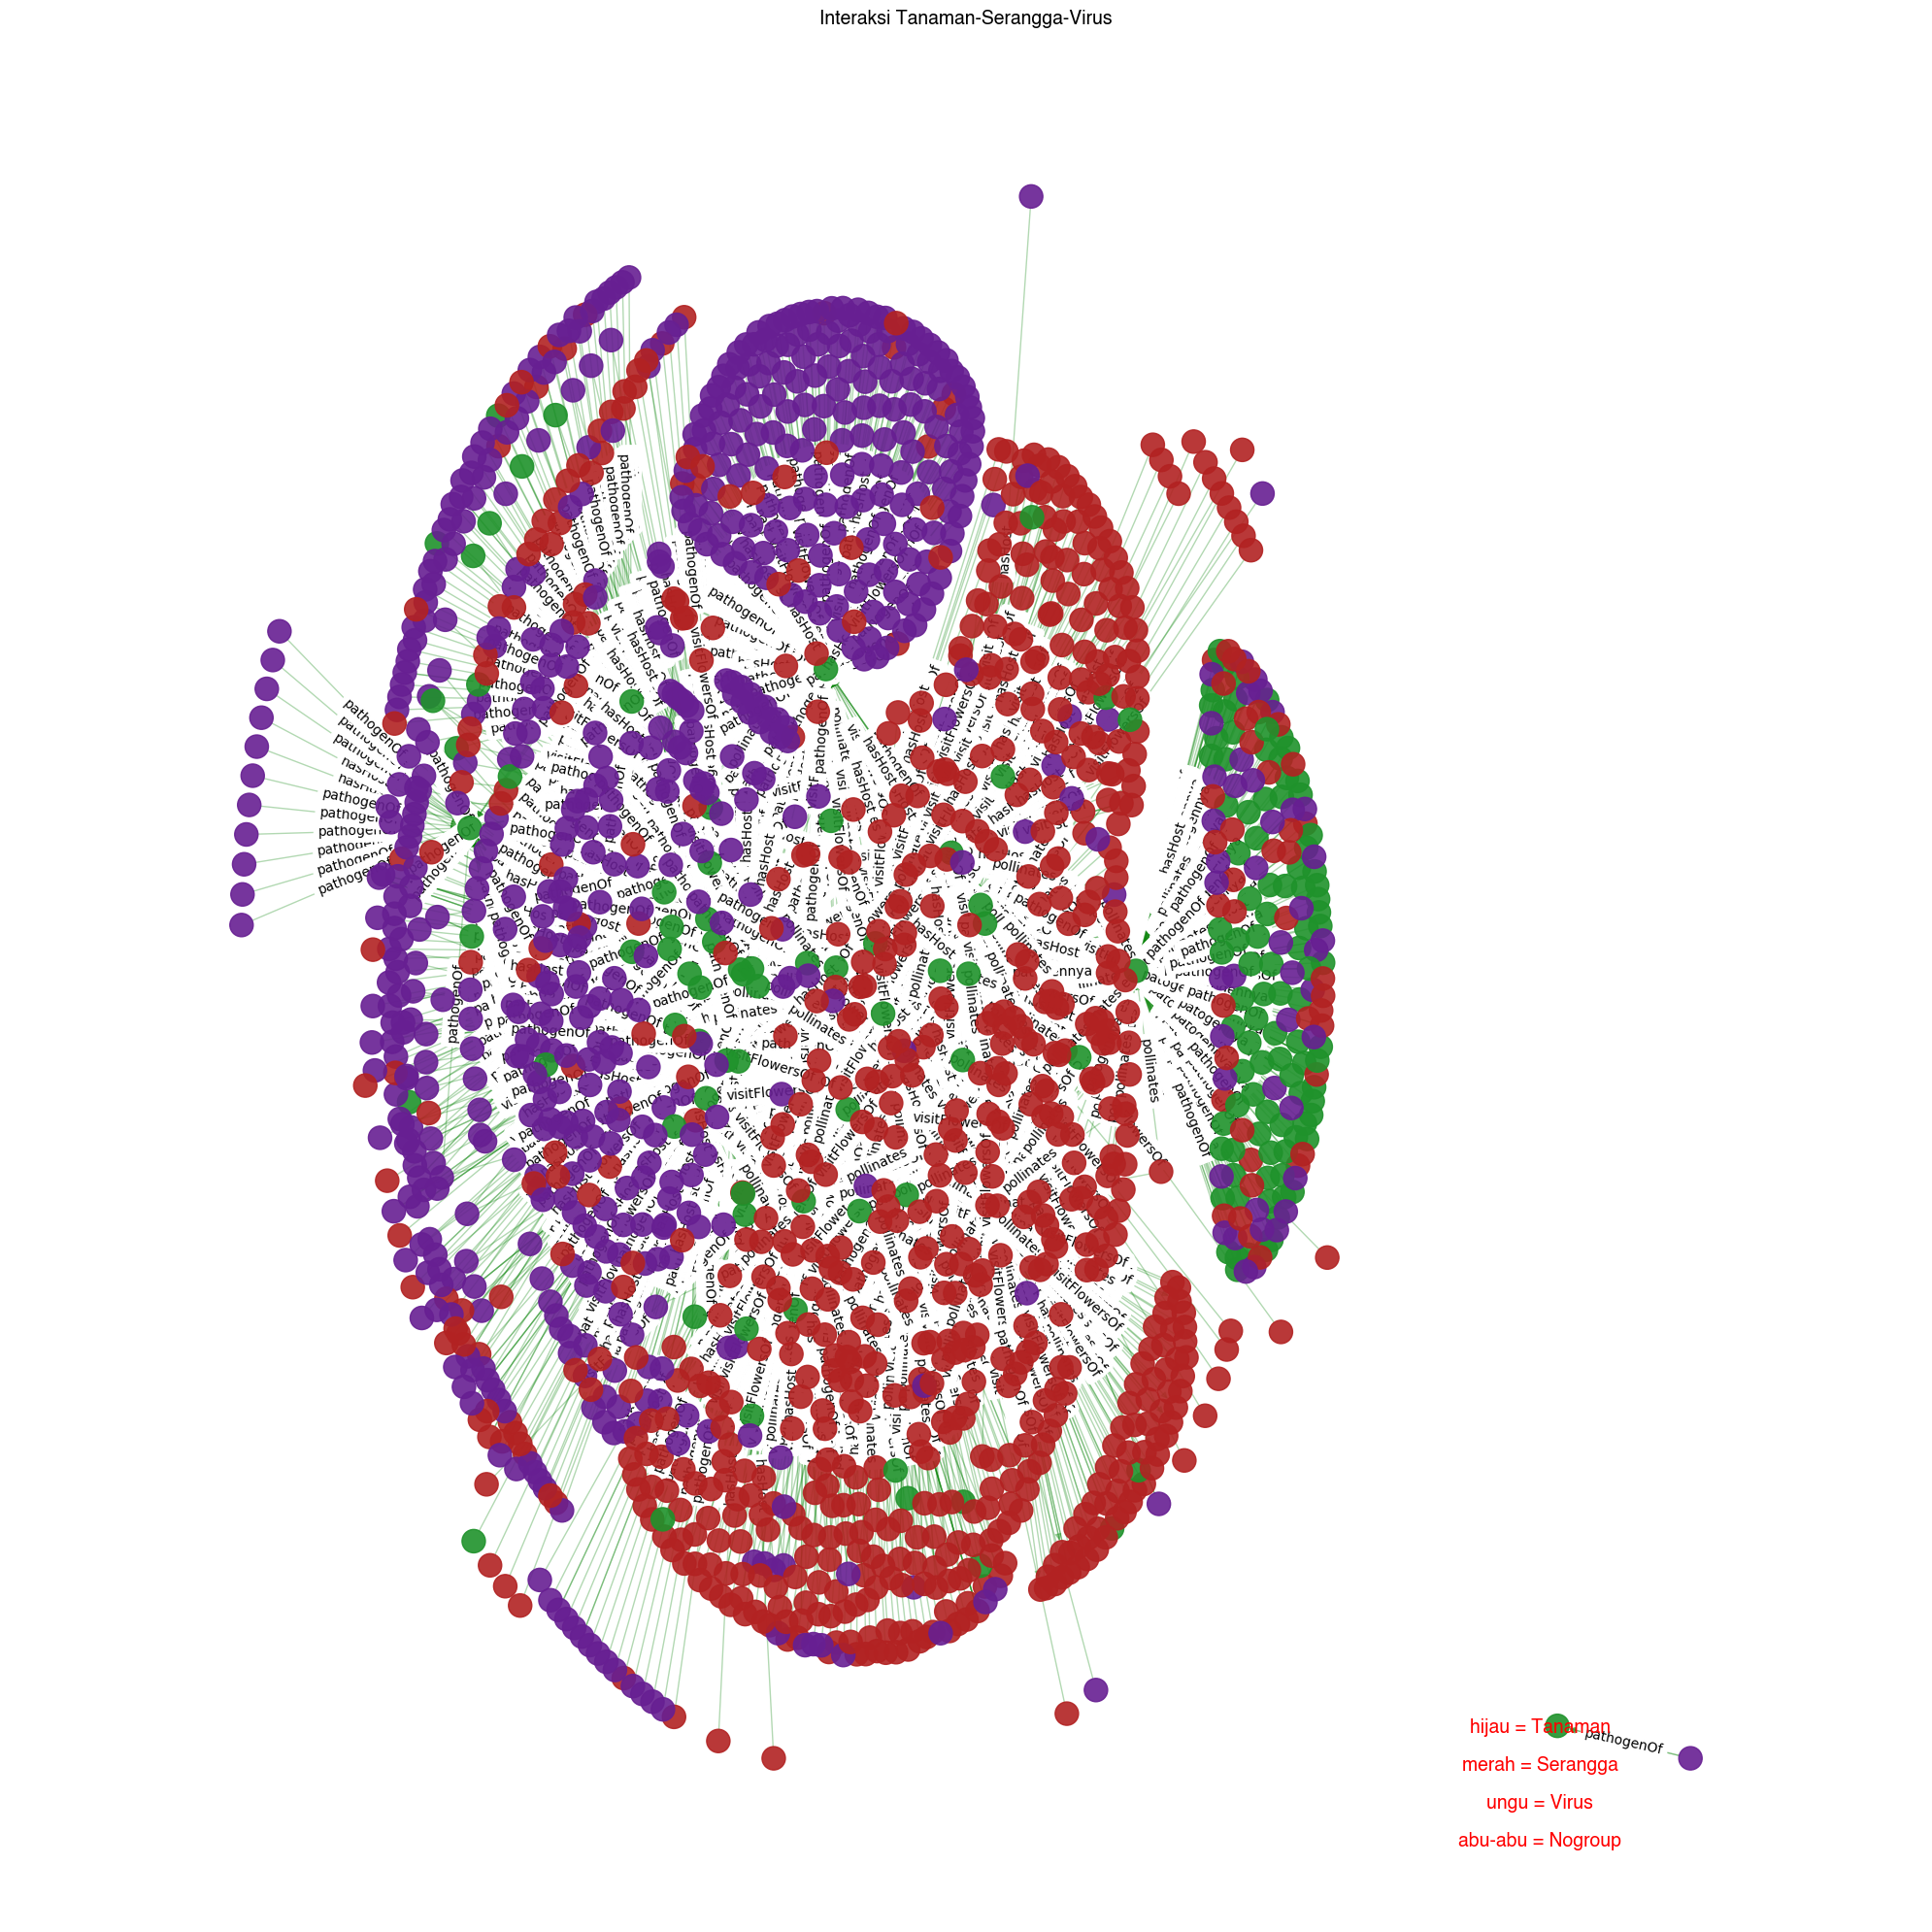

In [ ]:
# cuma tampilan, visualisasi graf
G=gnx

fig, ax = plt.subplots(figsize=(20, 20))

# Generate layout for visualization
# pos = nx.kamada_kawai_layout(G)
# pos = nx.spring_layout(G)
pos = nx.nx_agraph.graphviz_layout(G, prog="neato", args="")

# Visualize graph components
nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color='g')
nx.draw_networkx_nodes(G, pos, node_color=list(nx.get_node_attributes(G, "color").values()), alpha=0.9)

#node label
# for i in ['#b22222','#671f92','#1f922b','#EADDCA']: # filtering dengan bedakan warna node
#     label_options = {"ec": i, "fc": 'white', "alpha": 0.7}
#     nx.draw_networkx_labels(
#         nx.subgraph_view(G, filter_node=lambda n1: G.nodes(data=True)[n1].get("color", True) == i),
#         pos, 
#         font_size=10, 
#         bbox=label_options
#     )

#edge labels
edge_labels={x:i for i,x in zip(nx.get_edge_attributes(G, "label").values(),G.edges())}
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


# Title/legend
font = {"fontname": "Helvetica", "color": "k", "fontweight": "bold", "fontsize": 14}
ax.set_title("Interaksi Tanaman-Serangga-Virus", font)
# Change font color for legend
font["color"] = "r"

ax.text(
    0.80,
    0.10,
    "hijau = Tanaman",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)
ax.text(
    0.80,
    0.08,
    "merah = Serangga",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

ax.text(
    0.80,
    0.06,
    "ungu = Virus",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

ax.text(
    0.80,
    0.04,
    "abu-abu = Nogroup",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

# Resize figure for label readibility
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.show()